In [1]:
import torch

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


Install and import necessary libraries

In [2]:
!pip install opencv-python


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import cv2
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Load CIFAR-10 Dataset , Apply Preprocessing

In [8]:
#Define Image Transformations
transform = transforms.Compose([
    transforms.ToTensor(),                      # convert image to tensor
    transforms.Normalize((0.5, 0.5, 0.5),       # normalize RGB channels
                         (0.5, 0.5, 0.5))
])


In [9]:
# Download & Load CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)


In [10]:
# create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False
)


In [11]:
# define class labels
classes = (
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
)


Labels: ['ship', 'ship', 'bird', 'bird', 'horse', 'frog', 'horse', 'airplane']


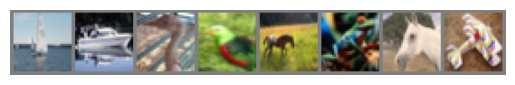

In [12]:
# visualise some sample images
def imshow(img):
    img = img / 2 + 0.5   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# get a batch of images
images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images[:8]))
print("Labels:", [classes[label] for label in labels[:8]])


Image Preprocessing & Enhancement using OpenCV

In [13]:
# Get one image from dataset (not dataloader)
image, label = train_dataset[0]

# Convert tensor → numpy
img_np = image.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  # C,H,W → H,W,C

# Unnormalize (back to 0–255)
img_np = (img_np * 0.5 + 0.5) * 255
img_np = img_np.astype(np.uint8)

# Convert RGB → BGR (OpenCV format)
img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

print("Class label:", classes[label])


Class label: frog


In [17]:
# Adjust Brightness & Contrast
alpha = 1.5   # contrast control (1.0 = no change)
beta = 30     # brightness control
# new_image = alpha * image + beta   #alpha: contrast, beta:brightness

bright_contrast_img = cv2.convertScaleAbs(img_bgr, alpha=alpha, beta=beta)


In [18]:
# Apply Filtering (Gaussian Blur)
blurred_img = cv2.GaussianBlur(img_bgr, (5, 5), 0)


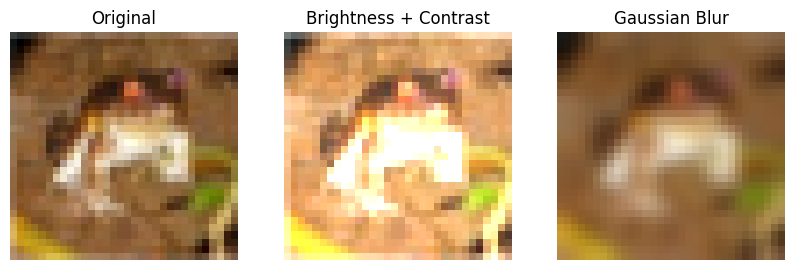

In [19]:
# display og vs enhanced images
plt.figure(figsize=(10,4))

plt.subplot(1,3,1)
plt.title("Original")
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,2)
plt.title("Brightness + Contrast")
plt.imshow(cv2.cvtColor(bright_contrast_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1,3,3)
plt.title("Gaussian Blur")
plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


Define a CNN Architecture

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

        # Activation
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x


In [21]:
model = SimpleCNN().to(device)
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


Defining Loss Function, Optimizer & Training the CNN

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
num_epochs = 20

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()   # training mode

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # 1. Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # 2. Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training Finished!")


Epoch [1/20], Loss: 1.3520
Epoch [2/20], Loss: 0.9860
Epoch [3/20], Loss: 0.8307
Epoch [4/20], Loss: 0.7179
Epoch [5/20], Loss: 0.6160
Epoch [6/20], Loss: 0.5275
Epoch [7/20], Loss: 0.4408
Epoch [8/20], Loss: 0.3636
Epoch [9/20], Loss: 0.2971
Epoch [10/20], Loss: 0.2343
Epoch [11/20], Loss: 0.1832
Epoch [12/20], Loss: 0.1479
Epoch [13/20], Loss: 0.1238
Epoch [14/20], Loss: 0.1067
Epoch [15/20], Loss: 0.0917
Epoch [16/20], Loss: 0.0822
Epoch [17/20], Loss: 0.0801
Epoch [18/20], Loss: 0.0727
Epoch [19/20], Loss: 0.0708
Epoch [20/20], Loss: 0.0680
Training Finished!


Model Evaluation

In [24]:
model.eval()   # evaluation mode

correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 70.30%


In [26]:
! pip install seaborn

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [29]:
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)


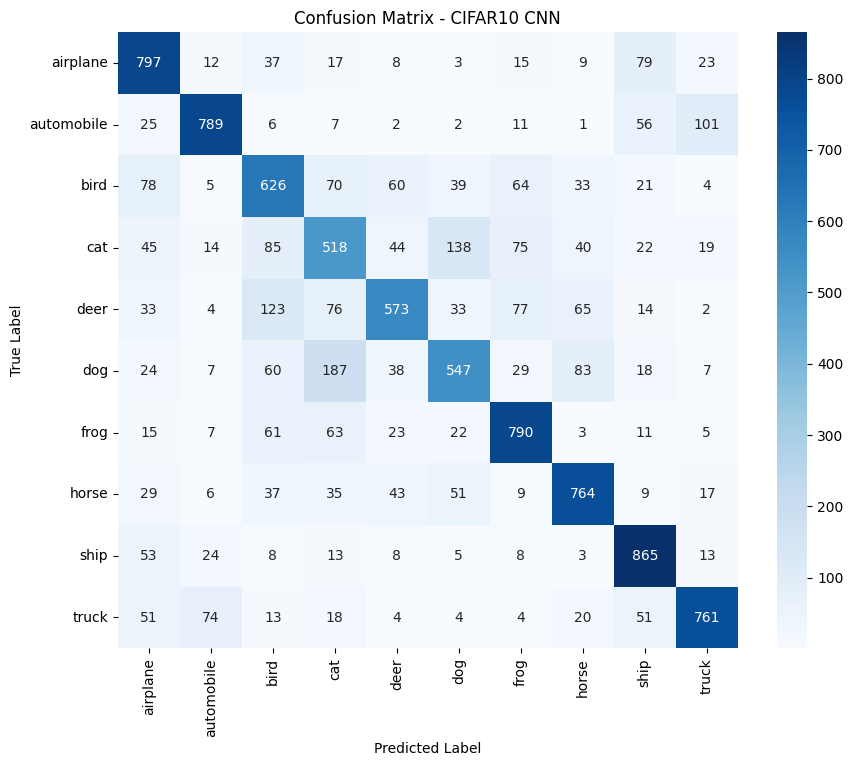

In [30]:
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - CIFAR10 CNN")
plt.show()


Visualizng test predictions (Actual vs Predicted)

In [31]:
# taking a batch of test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)
labels = labels.to(device)


In [32]:
# run model prediction on that
model.eval()

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)


In [33]:
def show_predictions(images, labels, preds, num_images=8):
    images = images[:num_images].cpu()
    labels = labels[:num_images].cpu()
    preds = preds[:num_images].cpu()

    plt.figure(figsize=(15, 4))

    for i in range(num_images):
        img = images[i] / 2 + 0.5  # unnormalize
        img = img.numpy()
        img = np.transpose(img, (1, 2, 0))

        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}")
        plt.axis("off")

    plt.show()


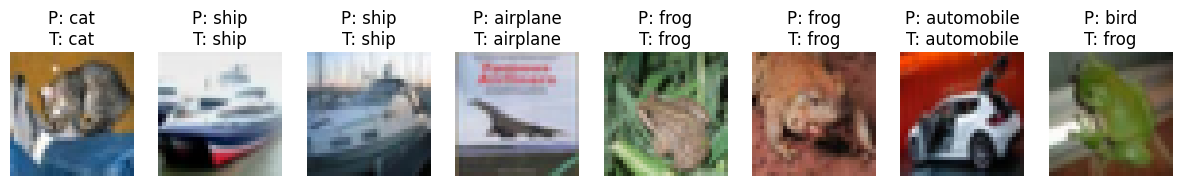

In [34]:
show_predictions(images, labels, preds)


In [35]:
!pip install gradio
import gradio as gr
from PIL import Image


In [36]:
def preprocess_image(img):
    """
    img: PIL Image
    returns: torch tensor (1, 3, 32, 32)
    """
    img = img.resize((32, 32))
    img = np.array(img)

    # Convert grayscale to RGB if needed
    if img.ndim == 2:
        img = np.stack([img]*3, axis=-1)

    # Normalize to [0,1]
    img = img / 255.0

    # Normalize like CIFAR-10
    img = (img - 0.5) / 0.5

    # HWC → CHW
    img = np.transpose(img, (2, 0, 1))

    img = torch.tensor(img, dtype=torch.float32)
    img = img.unsqueeze(0).to(device)

    return img


In [37]:
def predict(image):
    model.eval()

    input_tensor = preprocess_image(image)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, pred = torch.max(outputs, 1)

    return classes[pred.item()]


In [38]:
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil", label="Upload an image"),
    outputs=gr.Label(label="Predicted Class"),
    title="CIFAR-10 Image Classification (CNN)",
    description="Upload an image to classify it into one of the CIFAR-10 classes."
)


In [39]:
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e19bd371e90de640cd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [40]:
model_path = "cifar10_cnn.pth"
torch.save(model.state_dict(), model_path)

print("Model saved successfully!")


Model saved successfully!
